In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from tensorflow import keras
import tensorflow as tf
import random

import warnings
warnings.filterwarnings("ignore")


In [5]:
# Generate Series

xlim = 60

x = np.arange(0, xlim, 0.1)
y = np.sin(x)
y_2 = np.cos(x)
df = pd.DataFrame([y, y_2],).T
df.columns=['sine','cosine']

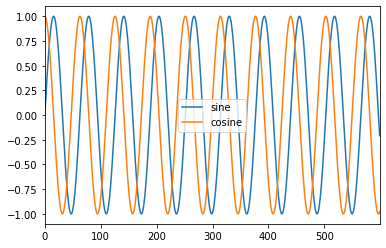

In [6]:
signal.plot()

In [7]:
# Split Data
train, test = df[:-12], df[-12:]
print(train.shape, test.shape)

(588, 2) (12, 2)


In [8]:
# transform data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [28]:
n_input = 50 # timesteps
n_features = df.shape[1]
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=60)

In [29]:
# To Measure uncertainty
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [30]:
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(n_input, n_features)))
model.add(MCDropout(0.15))

model.add(LSTM(200,return_sequences=True))
model.add(MCDropout(0.15))

model.add(LSTM(200))
model.add(MCDropout(0.15))

model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

In [31]:
history = model.fit_generator(generator, 
                              epochs=10, 
                              verbose=0)
model.summary()


  ...
    to  
  ['...']
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 200)           162400    
_________________________________________________________________
mc_dropout_3 (MCDropout)     (None, 50, 200)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 200)           320800    
_________________________________________________________________
mc_dropout_4 (MCDropout)     (None, 50, 200)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               320800    
_________________________________________________________________
mc_dropout_5 (MCDropout)     (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              

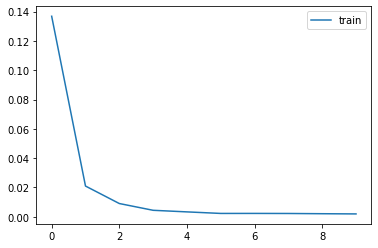

In [32]:
plt.plot(history.history['loss'], label='train')
# val plot missing
plt.legend()


### Predict next 100 Steps and get confidence intervals

In [54]:
%%time

pred_list = []
confidence_interval = [ ]

batch = train[-n_input:].reshape((1, n_input, n_features)) # take the last steps

for i in range(n_input+100):   # input=steps
    
        
    # Get intervals
    y_probas = np.stack([model(batch, training=True)
                         for sample in range(100)]) # make 100 predictions
    y_mu = y_probas.mean(axis=0)
    y_std = y_probas.std(axis=0)
    
    max_lim = y_mu + (2*y_std)  # mean + 2*std [sine, cosine ]
    min_lim = y_mu - (2*y_std)  # mean - 2*std
    
    confidence_interval.append((max_lim, min_lim))
    
    pred_list.append(model.predict(batch)[0]) 
    
    removed_onne = batch[:,1:,:] # remove one step on the 2nd dimention, 
        
    batch = np.append(removed_onne, [[pred_list[i]]], axis=1)
    
    


CPU times: user 22min 22s, sys: 0 ns, total: 22min 22s
Wall time: 22min 20s


### Make Prediction

In [55]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=pd.RangeIndex(start=588, stop=738, step=1), columns=['sine', 'cosine'])

### Confidence Intervals

In [56]:
max_bound_list = []
min_bound_list = []

for i in range(0,len(confidence_interval)):
    
    max_bound = confidence_interval[i][0]
    min_bound = confidence_interval[i][1]
    max_bound_list.append(max_bound.flatten())
    min_bound_list.append(min_bound.flatten())

    
fill_max = pd.DataFrame(scaler.inverse_transform(max_bound_list), 
             index=pd.RangeIndex(start=588, stop=738, step=1), columns=['sine_max', 'cosine_max'])

fill_min = pd.DataFrame(scaler.inverse_transform(min_bound_list), 
             index=pd.RangeIndex(start=588, stop=738, step=1), columns=['sine_min', 'cosine_min'])

### Plot Results

(500, 750)

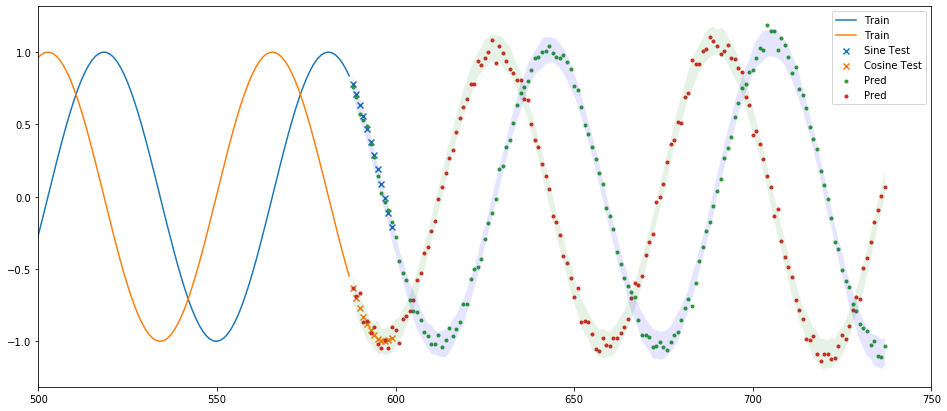

In [57]:
plt.figure(figsize=(16, 7))
plt.plot(df[:-12], label="Train")
plt.scatter(df[-12:].index.values , df[-12:]['sine'], marker='x',label="Sine Test")
plt.scatter(df[-12:].index.values , df[-12:]['cosine'], marker='x',label="Cosine Test")


plt.scatter(df_predict.index.values , df_predict['sine'], marker='.',label="Pred")
plt.scatter(df_predict.index.values , df_predict['cosine'], marker='.',label="Pred")


plt.fill_between(fill_min.index.values, fill_min['sine_min'], fill_max['sine_max'],facecolor='blue', alpha=0.1) #std curves.
plt.fill_between(fill_min.index.values, fill_min['cosine_min'], fill_max['cosine_max'],facecolor='green', alpha=0.1) #std curves.


plt.legend()
plt.xlim(500,750)